In [428]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

os.chdir('/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/')
# Add the 'src' directory to the Python path
from src.process_data import compute_indices_for_df, prepare_model_data, compute_monthly_indices_for_df
from src.visualize import plot_numerical_distributions, plot_confusion_matrix
from src.utils import FocalLoss

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Deep learning package 
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.classification import Accuracy

from torch.utils.data import Dataset, DataLoader, random_split

#["EVI", "NDRE", "GNDVI", "MoistureIndex"]

In [429]:
df = pd.read_csv('data/Model/Input/train_monthly_indeces.csv', index_col=0)
# Identify time-series columns (all M1-M23 features)
columns_to_drop = [col for col in df.columns if 'LSWI' in col or 'LCI' in col or 'MoistureIndex' in col]
df = df.drop(columns=columns_to_drop)

time_series_columns = [col for col in df.columns if col.startswith("M")]

# Ensure `HDate` is numeric
df["HDate"] = pd.to_datetime(df["HDate"], errors='coerce').dt.month

# Category Mapping
category_mapper = {'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}
df["category"] = df["category"].map(category_mapper)

In [432]:
df = df.dropna(subset=['M1_EVI'])

In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7866 entries, 0 to 7887
Data columns (total 89 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           7866 non-null   int64  
 1   category         7866 non-null   int64  
 2   Crop             7866 non-null   object 
 3   State            7866 non-null   object 
 4   District         7866 non-null   object 
 5   Sub-District     7866 non-null   object 
 6   SDate            7866 non-null   object 
 7   HDate            7866 non-null   int32  
 8   CropCoveredArea  7866 non-null   int64  
 9   CHeight          7866 non-null   int64  
 10  CNext            7866 non-null   object 
 11  CLast            7866 non-null   object 
 12  CTransp          7866 non-null   object 
 13  IrriType         7866 non-null   object 
 14  IrriSource       7866 non-null   object 
 15  IrriCount        7866 non-null   int64  
 16  WaterCov         7866 non-null   int64  
 17  ExpYield         78

In [436]:
num_farms = df.FarmID.nunique()
# Extract Time-Series Features (EVI, NDRE, GNDVI for 23 months)
time_series_cols = [col for col in df.columns if col.startswith('M')]
X = df[time_series_cols].fillna(0).values.reshape(num_farms, 23, 3)  # (Farms, TimeSteps=23, Features=3)
y = df['category'].values  # (Farms, ) - Multi-Class Labels
X.shape, y.shape

((7866, 23, 3), (7866,))

## Dataset Prepration

In [439]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data import DataLoader, TensorDataset
# Split into train and validation sets (80% Train, 20% Validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create Dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

# Balance Class while training
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size,  sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

### Data Augumenation 

In [499]:
from scipy.interpolate import CubicSpline

class TimeSeriesAugmentation:
    def __init__(self, jitter_std=0.02, scale_factor=0.1, mag_warp_k=3, time_warp_k=3, perm_segments=5):
        self.jitter_std = jitter_std
        self.scale_factor = scale_factor
        self.mag_warp_k = mag_warp_k
        self.time_warp_k = time_warp_k
        self.perm_segments = perm_segments

    def jitter(self, x):
        """Add Gaussian noise."""
        return x + np.random.normal(0, self.jitter_std, x.shape)

    def scale(self, x):
        """Scale time-series."""
        factor = np.random.normal(1, self.scale_factor, (x.shape[1],))
        return x * factor

    def magnitude_warp(self, x):
        """Apply a smooth non-linear transformation using cubic splines."""
        orig_steps = np.arange(x.shape[0])
        random_warp = np.random.normal(1, 0.2, (self.mag_warp_k, x.shape[1]))
        warp_steps = np.linspace(0, x.shape[0] - 1, self.mag_warp_k)
        cs = CubicSpline(warp_steps, random_warp, axis=0)
        return x * cs(orig_steps)

    def time_warp(self, x):
        """Stretch or compress sections of time-series using cubic splines."""
        orig_steps = np.arange(x.shape[0])
        random_warp = np.random.normal(1, 0.2, (self.time_warp_k,))
        warp_steps = np.linspace(0, x.shape[0] - 1, self.time_warp_k)
        cs = CubicSpline(warp_steps, random_warp)
        return x[np.clip(cs(orig_steps).astype(int), 0, x.shape[0] - 1)]

    def permute(self, x):
        """Randomly shuffle time-series segments."""
        idx = np.random.permutation(self.perm_segments)
        x_split = np.array_split(x, self.perm_segments)
        return np.concatenate([x_split[i] for i in idx], axis=0)

    def __call__(self, x):
        """Apply a combination of augmentations."""
        if np.random.rand() < 0.5: x = self.jitter(x)
        if np.random.rand() < 0.5: x = self.scale(x)
        if np.random.rand() < 0.3: x = self.magnitude_warp(x)
        if np.random.rand() < 0.3: x = self.time_warp(x)
        if np.random.rand() < 0.3: x = self.permute(x)
        return x

class AugmentedTimeSeriesDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        self.augmenter = TimeSeriesAugmentation()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.augment:
            x = self.augmenter(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [544]:
# Convert to PyTorch tensors
batch_size = 32
train_dataset_aug = AugmentedTimeSeriesDataset(X_train, y_train, augment=True)
valid_dataset_aug = AugmentedTimeSeriesDataset(X_valid, y_valid, augment=False)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, sampler=sampler)
valid_loader_aug = DataLoader(valid_dataset_aug, batch_size=batch_size, shuffle=False)

## Feature Pyramid Network (FPN)

In [547]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FPN1D(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes=4):
        super(FPN1D, self).__init__()

        # Bottom-Up Pathway
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)  # Downsample (23 → 12)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)  # Downsample (12 → 6)

        # Lateral Connections
        self.lateral2 = nn.Conv1d(128, 128, kernel_size=1)
        self.lateral1 = nn.Conv1d(64, 64, kernel_size=1)

        # Top-Down Pathway (Interpolation-based Upsampling)
        self.up2 = nn.Conv1d(256, 128, kernel_size=1)  # Reduce channels
        self.up1 = nn.Conv1d(128, 64, kernel_size=1)   # Reduce channels

        # Fully Connected Layer for Classification
        self.fc = nn.Linear(64 * sequence_length, 128)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to (batch, channels, time)

        # Bottom-Up Pathway
        c1 = F.relu(self.conv1(x))  # Shape: (batch, 64, 23)
        c2 = F.relu(self.conv2(c1))  # Shape: (batch, 128, 12)
        c3 = F.relu(self.conv3(c2))  # Shape: (batch, 256, 6)

        # Top-Down Pathway with Lateral Connections
        p2 = self.up2(c3)  # Reduce channels (batch, 128, 6)
        p2 = F.interpolate(p2, size=c2.shape[2], mode="linear", align_corners=False)  # Match c2 length (12)
        p2 = F.relu(p2 + self.lateral2(c2))  

        p1 = self.up1(p2)  # Reduce channels (batch, 64, 12)
        p1 = F.interpolate(p1, size=c1.shape[2], mode="linear", align_corners=False)  # Match c1 length (23)
        p1 = F.relu(p1 + self.lateral1(c1))  

        # Flatten and Classification Layer
        r1 = p1.view(p1.shape[0], -1)  # (batch, 64 * 23)
        features = self.fc(p1)
        output = self.out(features)

        return output

class FPN1D_V1(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes=4, return_features=False):
        super(FPN1D_V1, self).__init__()
        self.return_features = return_features
        
        # Bottom-Up Pathway
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)  # Downsample (23 → 12)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)  # Downsample (12 → 6)

        # Lateral Connections
        self.lateral2 = nn.Conv1d(128, 128, kernel_size=1)
        self.lateral1 = nn.Conv1d(64, 64, kernel_size=1)

        # Top-Down Pathway
        self.up2 = nn.Conv1d(256, 128, kernel_size=1)  
        self.up1 = nn.Conv1d(128, 64, kernel_size=1)   

        # Feature and Classification Layers
        self.fc = nn.Linear(64 * sequence_length, 128)  # Feature layer
        self.out = nn.Linear(128, num_classes)  # Classification layer

    def forward(self, x, return_features=None):
        if return_features is None:
            return_features = self.return_features
            
        x = x.permute(0, 2, 1)  # Reshape to (batch, channels, time)

        # Bottom-Up Pathway
        c1 = F.relu(self.conv1(x))
        c2 = F.relu(self.conv2(c1))
        c3 = F.relu(self.conv3(c2))

        # Top-Down Pathway
        p2 = self.up2(c3)
        p2 = F.interpolate(p2, size=c2.shape[2], mode="linear", align_corners=False)
        p2 = F.relu(p2 + self.lateral2(c2))

        p1 = self.up1(p2)
        p1 = F.interpolate(p1, size=c1.shape[2], mode="linear", align_corners=False)
        p1 = F.relu(p1 + self.lateral1(c1))

        # Feature Extraction
        r1 = p1.view(p1.shape[0], -1)  # Flatten features
        features = self.fc(r1)  # Features before classification

        output = self.out(features)  # Class predictions

        if return_features:
            return features, output   # Return feature values instead of class output

        return output

In [618]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction='mean'):
        """
        Focal Loss for handling class imbalance.
        :param alpha: Class weights (tensor), helps address class imbalance
        :param gamma: Focusing parameter to down-weight easy examples
        :param reduction: 'mean' or 'sum' for loss aggregation
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(weight=alpha, reduction='none') if alpha is not None else nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets)  # Compute CE loss
        pt = torch.exp(-ce_loss)  # Compute pt = exp(-CE)
        focal_loss = (1 - pt) ** self.gamma * ce_loss  # Compute Focal Loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss  # If no reduction, return as-is

# Balanced Softmax Loss Function
class BalancedSoftmaxLoss(nn.Module):
    def __init__(self, class_counts, tau=1.0):
        super(BalancedSoftmaxLoss, self).__init__()
        self.class_counts = torch.tensor(class_counts, dtype=torch.float32)
        self.tau = tau

    def forward(self, logits, targets):
        logits = logits / self.tau
        class_weights = torch.log(self.class_counts.to(logits.device))
        logits_balanced = logits - class_weights
        return F.cross_entropy(logits_balanced, targets)

In [620]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
input_channels = X_train_tensor.shape[2]  # Number of features (EVI, NDRE, GNDVI)
sequence_length = X_train_tensor.shape[1]  # 23 months
num_classes = 4  # Crop Health Classes
model = FPN1D_V1(input_channels, sequence_length, num_classes)
criterion = FocalLoss() #
optimizer = optim.RMSprop(model.parameters(), lr=0.0007, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Loop
epochs = 75
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/75], Loss: 0.6838
Epoch [2/75], Loss: 0.6671
Epoch [3/75], Loss: 0.6611
Epoch [4/75], Loss: 0.6515
Epoch [5/75], Loss: 0.6492
Epoch [6/75], Loss: 0.6423
Epoch [7/75], Loss: 0.6320
Epoch [8/75], Loss: 0.6352
Epoch [9/75], Loss: 0.6303
Epoch [10/75], Loss: 0.6258
Epoch [11/75], Loss: 0.6276
Epoch [12/75], Loss: 0.6311
Epoch [13/75], Loss: 0.6285
Epoch [14/75], Loss: 0.6290
Epoch [15/75], Loss: 0.6249
Epoch [16/75], Loss: 0.6256
Epoch [17/75], Loss: 0.6173
Epoch [18/75], Loss: 0.6148
Epoch [19/75], Loss: 0.6093
Epoch [20/75], Loss: 0.6051
Epoch [21/75], Loss: 0.5958
Epoch [22/75], Loss: 0.5754
Epoch [23/75], Loss: 0.5647
Epoch [24/75], Loss: 0.5439
Epoch [25/75], Loss: 0.5212
Epoch [26/75], Loss: 0.4987
Epoch [27/75], Loss: 0.4713
Epoch [28/75], Loss: 0.4534
Epoch [29/75], Loss: 0.4428
Epoch [30/75], Loss: 0.4382
Epoch [31/75], Loss: 0.4450
Epoch [32/75], Loss: 0.4330
Epoch [33/75], Loss: 0.4409
Epoch [34/75], Loss: 0.4363
Epoch [35/75], Loss: 0.4340
Epoch [36/75], Loss: 0.4258
E

In [638]:
# Evaluation
model.eval()
torch.save(model.state_dict(), "models/fpn1d_final_stop.pth")
y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        y_preds.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

In [640]:
# Classification Report
classification_rep = classification_report(y_true, y_preds)
f1 = f1_score(y_true, y_preds, average='weighted')

print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.64      0.72      1298
           1       0.07      0.17      0.10        95
           2       0.07      0.13      0.10        97
           3       0.05      0.12      0.07        84

    accuracy                           0.55      1574
   macro avg       0.26      0.26      0.25      1574
weighted avg       0.70      0.55      0.61      1574


Weighted F1 Score: 0.6120943150428081


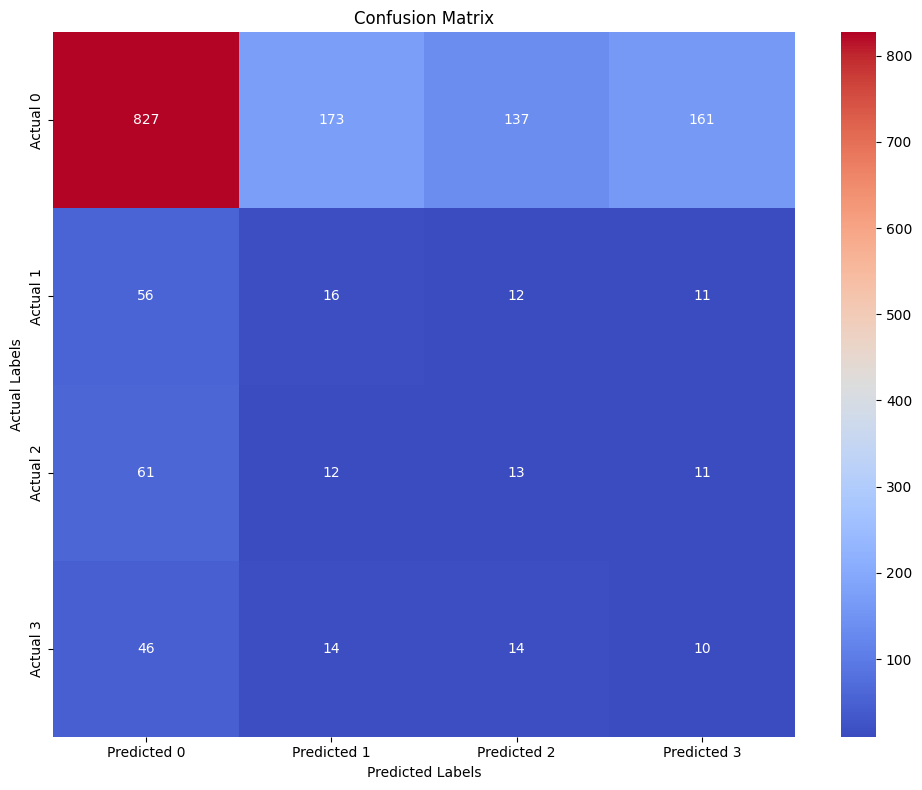

In [642]:
plot_confusion_matrix(y_valid, y_preds)

## U-Net model

### Base U-Net

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet1D(nn.Module):
    def __init__(self, input_channels=3, seq_length=23, num_classes=2):
        super(UNet1D, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.pool = nn.AdaptiveAvgPool1d(1)  # Global Pooling

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.3)

        # Xavier Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from [B, 23, 3] → [B, 3, 23]

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.pool(x).squeeze(-1)  # [B, 128, 1] → [B, 128]

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # [B, num_classes]
        return x

In [158]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
num_classes = len(np.unique(y_train))  
unet_model = UNet1D(input_channels=3, seq_length=23, num_classes=num_classes)
unet_model = unet_model.to(device)

# Loss function
#criterion = FocalLoss() #torch.nn.CrossEntropyLoss() #weight=class_weights
# Define Class Counts for Balanced Softmax
criterion = FocalLoss()

# Optimizer
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

epochs=100
# Training Loop
for epoch in range(epochs):
    unet_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = unet_model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        nn.utils.clip_grad_norm_(unet_model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()

        running_loss += loss.item()
        
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 0.7823
Epoch [2/100], Loss: 0.7560
Epoch [3/100], Loss: 0.7486
Epoch [4/100], Loss: 0.7280
Epoch [5/100], Loss: 0.7185
Epoch [6/100], Loss: 0.7135
Epoch [7/100], Loss: 0.6907
Epoch [8/100], Loss: 0.6810
Epoch [9/100], Loss: 0.6689
Epoch [10/100], Loss: 0.6634
Epoch [11/100], Loss: 0.6672
Epoch [12/100], Loss: 0.6616
Epoch [13/100], Loss: 0.6679
Epoch [14/100], Loss: 0.6661
Epoch [15/100], Loss: 0.6599
Epoch [16/100], Loss: 0.6557
Epoch [17/100], Loss: 0.6481
Epoch [18/100], Loss: 0.6360
Epoch [19/100], Loss: 0.6294
Epoch [20/100], Loss: 0.6065
Epoch [21/100], Loss: 0.5955
Epoch [22/100], Loss: 0.5852
Epoch [23/100], Loss: 0.5637
Epoch [24/100], Loss: 0.5438
Epoch [25/100], Loss: 0.5157
Epoch [26/100], Loss: 0.4821
Epoch [27/100], Loss: 0.4666
Epoch [28/100], Loss: 0.4462
Epoch [29/100], Loss: 0.4305
Epoch [30/100], Loss: 0.4238
Epoch [31/100], Loss: 0.4157
Epoch [32/100], Loss: 0.4207
Epoch [33/100], Loss: 0.4210
Epoch [34/100], Loss: 0.4208
Epoch [35/100], Loss: 0

In [160]:
# Evaluation
unet_model.eval()
torch.save(unet_model.state_dict(), "models/unet_base_v1.pth")

y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch = X_batch.to(device)
        outputs = unet_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        y_preds.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

In [162]:
np.unique(y_preds)

array([0, 1, 2, 3])

In [164]:
# Classification Report
classification_rep = classification_report(y_true, y_preds)
f1 = f1_score(y_true, y_preds, average='weighted')

print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.49      0.62      1298
           1       0.06      0.09      0.07        95
           2       0.06      0.33      0.10        97
           3       0.07      0.11      0.08        84

    accuracy                           0.43      1574
   macro avg       0.26      0.25      0.22      1574
weighted avg       0.71      0.43      0.52      1574


Weighted F1 Score: 0.5228275016148647


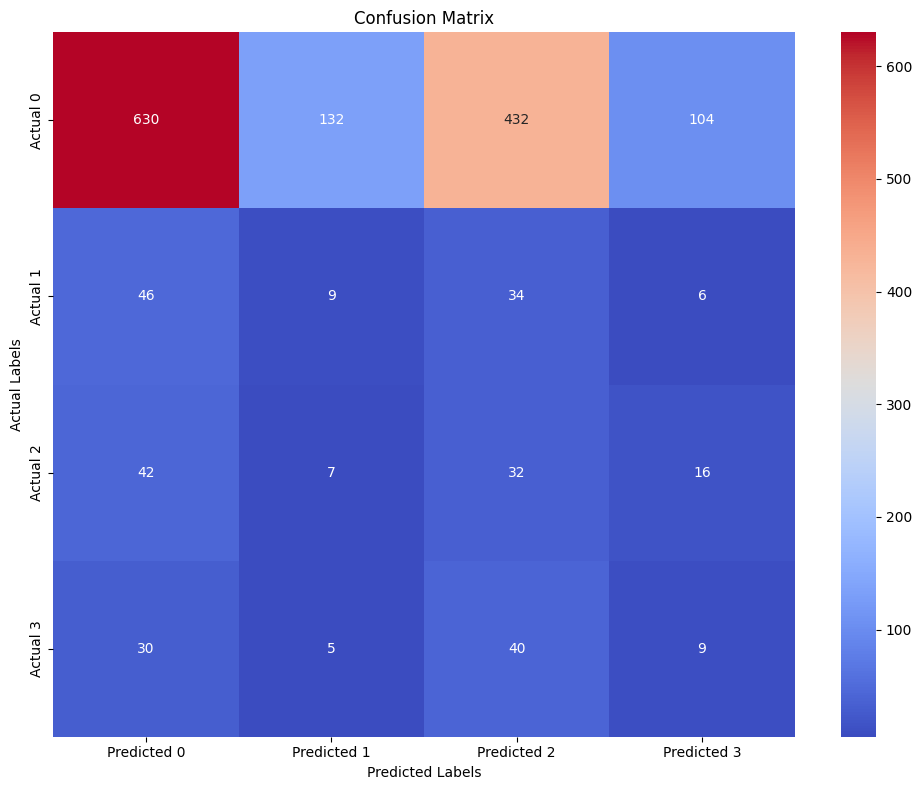

In [166]:
plot_confusion_matrix(y_valid, y_preds)

### Improved U-Net

In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block to enhance channel-wise features."""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        w = F.adaptive_avg_pool1d(x, 1).squeeze(-1)  # [B, C]
        w = F.relu(self.fc1(w))
        w = torch.sigmoid(self.fc2(w)).unsqueeze(-1)
        return x * w  # Channel-wise attention

class UNet1D_Improved(nn.Module):
    def __init__(self, input_channels=3, seq_length=23, num_classes=4):
        super(UNet1D_Improved, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.se1 = SEBlock(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, dilation=2, padding=2)  # Dilated Conv
        self.bn2 = nn.BatchNorm1d(64)
        self.se2 = SEBlock(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, dilation=2, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.se3 = SEBlock(128)

        self.pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)

        x = self.pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [171]:
class BalancedSoftmaxLoss(nn.Module):
    def __init__(self, class_freq):
        super(BalancedSoftmaxLoss, self).__init__()
        self.class_freq = torch.tensor(class_freq).float().to(device)

    def forward(self, logits, targets):
        adjusted_logits = logits - torch.log(self.class_freq + 1e-6)
        return F.cross_entropy(adjusted_logits, targets)

In [628]:
# Initialize model
num_classes = len(np.unique(y_train))  
unet_model1 = UNet1D_Improved(input_channels=3, seq_length=23, num_classes=num_classes)
unet_model1 = unet_model1.to(device)

# Define Class Counts for Balanced Softmax
#class_counts = torch.tensor([1298, 95, 97, 84], dtype=torch.float32, device=device).clone().detach()
criterion = nn.CrossEntropyLoss() #FocalLoss() #BalancedSoftmaxLoss(class_freq=class_counts)

# Optimizer
optimizer = torch.optim.AdamW(unet_model1.parameters(), lr=0.0007, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

epochs = 75

# Training Loop
for epoch in range(epochs):
    unet_model1.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = unet_model1(X_batch)  # Fixed model reference
        loss = criterion(outputs, y_batch)

        loss.backward()
        nn.utils.clip_grad_norm_(unet_model1.parameters(), max_norm=1.0)  # Fixed variable reference
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    
    # Pass the metric to ReduceLROnPlateau
    scheduler.step(avg_loss)  

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/75], Loss: 1.3754
Epoch [2/75], Loss: 1.3609
Epoch [3/75], Loss: 1.3428
Epoch [4/75], Loss: 1.3321
Epoch [5/75], Loss: 1.2941
Epoch [6/75], Loss: 1.2741
Epoch [7/75], Loss: 1.2316
Epoch [8/75], Loss: 1.1929
Epoch [9/75], Loss: 1.1540
Epoch [10/75], Loss: 1.1169
Epoch [11/75], Loss: 1.0723
Epoch [12/75], Loss: 1.0626
Epoch [13/75], Loss: 1.0141
Epoch [14/75], Loss: 0.9797
Epoch [15/75], Loss: 0.9450
Epoch [16/75], Loss: 0.9196
Epoch [17/75], Loss: 0.8977
Epoch [18/75], Loss: 0.8644
Epoch [19/75], Loss: 0.8403
Epoch [20/75], Loss: 0.8215
Epoch [21/75], Loss: 0.8192
Epoch [22/75], Loss: 0.7708
Epoch [23/75], Loss: 0.7488
Epoch [24/75], Loss: 0.7617
Epoch [25/75], Loss: 0.7074
Epoch [26/75], Loss: 0.7288
Epoch [27/75], Loss: 0.6858
Epoch [28/75], Loss: 0.6909
Epoch [29/75], Loss: 0.6759
Epoch [30/75], Loss: 0.6715
Epoch [31/75], Loss: 0.6386
Epoch [32/75], Loss: 0.6415
Epoch [33/75], Loss: 0.6174
Epoch [34/75], Loss: 0.6201
Epoch [35/75], Loss: 0.6256
Epoch [36/75], Loss: 0.5820
E

In [630]:
# Evaluation
unet_model1.eval()
torch.save(unet_model1.state_dict(), "models/unet_ipmd_final-v5.pth")

y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch = X_batch.to(device)
        outputs = unet_model1(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        y_preds.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

In [632]:
# Classification Report
classification_rep = classification_report(y_true, y_preds)
f1 = f1_score(y_true, y_preds, average='weighted')

print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.63      0.71      1298
           1       0.06      0.13      0.09        95
           2       0.04      0.06      0.05        97
           3       0.05      0.13      0.07        84

    accuracy                           0.54      1574
   macro avg       0.24      0.24      0.23      1574
weighted avg       0.68      0.54      0.60      1574


Weighted F1 Score: 0.5997991860154837


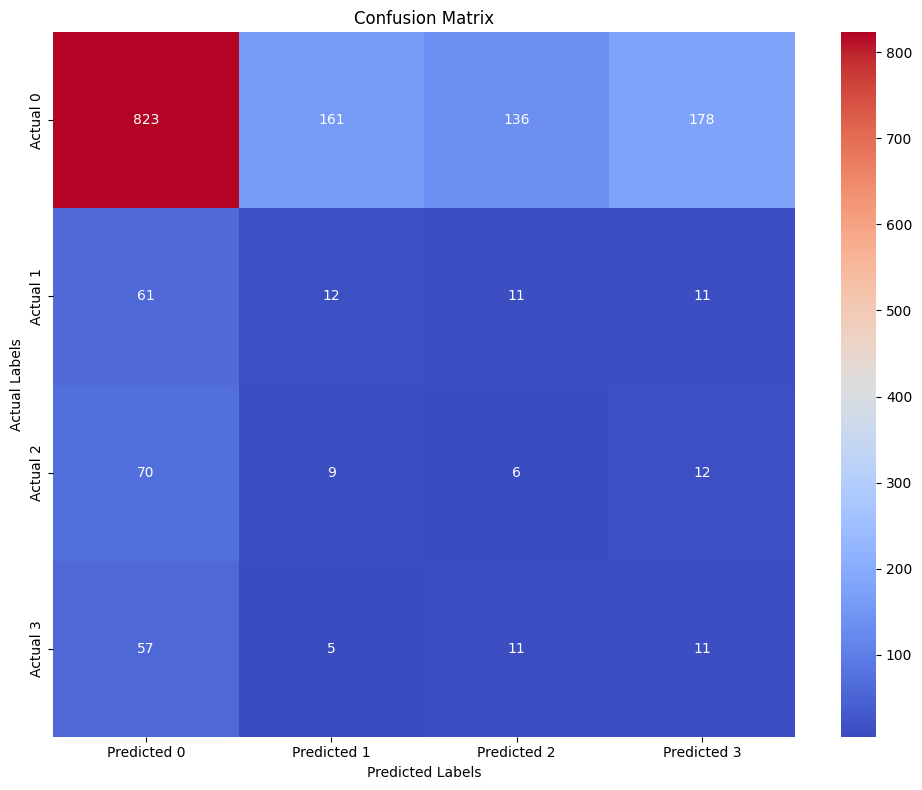

In [634]:
plot_confusion_matrix(y_valid, y_preds)

## Model Output 

### Test data prediction

In [644]:
import torch
import numpy as np

def get_model_predictions_cprob(model, dataloader, device):
    """
    Get predictions from the trained model for a given dataloader.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): DataLoader for validation or test data.
        device (torch.device): Device to run the model on ('cpu' or 'cuda').

    Returns:
        np.ndarray: Predicted outputs for the entire dataset.
    """
    model.eval()  # Set model to evaluation mode
    all_outputs = []

    with torch.no_grad():
        for batch in dataloader:
            # Handle different cases: batch may contain (X,) for test or (X, y) for validation
            if isinstance(batch, tuple) and len(batch) == 2:  # (X, y) case
                X_batch, _ = batch
            else:  # (X,) case (Test DataLoader)
                X_batch = batch[0]
            
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_outputs.append(outputs.cpu().numpy())

    # Concatenate all batch outputs into a single NumPy array
    return np.concatenate(all_outputs, axis=0)

In [646]:
# Load model 
# Recreate the model
fpn_model = FPN1D_V1(input_channels, sequence_length, num_classes)

# Load saved weights
fpn_model.load_state_dict(torch.load("models/fpn1d_final_stop.pth"))
fpn_model.eval()  # Set to evaluation mode

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_61321/1981844661.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fpn_model.load_state_dict(torch.load("models/

FPN1D_V1(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (lateral2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (lateral1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (up2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (up1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (fc): Linear(in_features=1472, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
)

In [648]:
# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions  = get_model_predictions_cprob(fpn_model, valid_loader, device)

In [650]:
predictions.shape

(1574, 4)

In [652]:
final_classes = np.argmax(predictions, axis=1)
final_classes.shape

(1574,)

## Test & Submission Prediction

### Test Prediction

In [654]:
test_df = pd.read_csv('data/Model/Input/test_monthly_ind.csv', index_col=0)
# Identify time-series columns (all M1-M23 features)
columns_to_drop = [col for col in test_df.columns if 'LSWI' in col or 'LCI' in col or 'MoistureIndex' in col]
test_df = test_df.drop(columns=columns_to_drop)

time_series_columns = [col for col in test_df.columns if col.startswith("M")]

# Ensure `HDate` is numeric
test_df["HDate"] = pd.to_datetime(test_df["HDate"], errors='coerce').dt.month

In [656]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 0 to 2717
Data columns (total 88 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           2718 non-null   int64  
 1   Crop             2718 non-null   object 
 2   State            2718 non-null   object 
 3   District         2718 non-null   object 
 4   Sub-District     2718 non-null   object 
 5   SDate            2718 non-null   object 
 6   HDate            2718 non-null   int32  
 7   CropCoveredArea  2718 non-null   int64  
 8   CHeight          2718 non-null   int64  
 9   CNext            2718 non-null   object 
 10  CLast            2718 non-null   object 
 11  CTransp          2718 non-null   object 
 12  IrriType         2718 non-null   object 
 13  IrriSource       2718 non-null   object 
 14  IrriCount        2718 non-null   int64  
 15  WaterCov         2718 non-null   int64  
 16  ExpYield         2718 non-null   int64  
 17  Season           27

In [658]:
num_farms_test = test_df.FarmID.nunique()
# Extract Time-Series Features (EVI, NDRE, GNDVI for 23 months)
X_test = test_df[time_series_cols].fillna(0).values.reshape(num_farms_test, 23, 3)  # (Farms, TimeSteps=23, Features=3)
# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Create Dataloaders
batch_size = 16
test_dataset = TensorDataset(X_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [660]:
## UNet Model Prediction 
unet_test_predictions = get_model_predictions_cprob(unet_model1, test_loader, device)
final_unet_classes = np.argmax(unet_test_predictions, axis=1)
np.unique(final_unet_classes)

array([0, 1, 2, 3])

In [662]:
unet_columns = ['pred_unet_class0', 'pred_unet_class1', 'pred_unet_class2', 'pred_unet_class3']
test_pp_df = pd.DataFrame(unet_test_predictions, columns=unet_columns)
test_pp_df['FarmID'] = test_df.FarmID
test_pp_df.to_csv('data/Model/Output/test_unet_pred_fs.csv', index=0)
test_pp_df.head()

,pred_unet_class0,pred_unet_class1,pred_unet_class2,pred_unet_class3,FarmID
0,1.010903,-0.415823,-3.862851,-3.556080,1329046
1,0.505590,-3.926801,-0.581413,-0.475892,1329051
2,0.247873,-3.802574,-3.588267,2.867522,1329154
3,0.866577,3.124789,-4.754453,-5.752990,1329334
4,0.969337,-2.608704,-6.131832,0.381876,1329335


In [664]:
## FPN Model Prediction 
fpn_test_predictions = get_model_predictions_cprob(fpn_model, test_loader, device)
final_fpn_classes = np.argmax(fpn_test_predictions, axis=1)
np.unique(final_fpn_classes)

array([0, 1, 2, 3])

In [666]:
fpn_columns = ['pred_fpn_class0', 'pred_fpn_class1', 'pred_fpn_class2', 'pred_fpn_class3']
fpn_test_df = pd.DataFrame(fpn_test_predictions, columns=fpn_columns)
#fpn_test_df.to_csv('data/Model/Output/test_fpn_pp.csv', index=0)

# Concatenate both DataFrames
test_pp_df = pd.concat([test_pp_df, fpn_test_df], axis=1)
test_pp_df.head()

,pred_unet_class0,pred_unet_class1,pred_unet_class2,pred_unet_class3,FarmID,pred_fpn_class0,pred_fpn_class1,pred_fpn_class2,pred_fpn_class3
0,1.010903,-0.415823,-3.862851,-3.556080,1329046,0.076909,-0.390377,0.139129,-0.334003
1,0.505590,-3.926801,-0.581413,-0.475892,1329051,0.103482,-0.494643,0.114535,-0.247978
2,0.247873,-3.802574,-3.588267,2.867522,1329154,0.390070,-1.180574,-0.677827,0.619984
3,0.866577,3.124789,-4.754453,-5.752990,1329334,0.307861,0.707604,-0.302095,-2.060045
4,0.969337,-2.608704,-6.131832,0.381876,1329335,0.604193,-2.230839,-0.400121,0.812520


In [668]:
test_pp_df.to_csv('data/Model/Output/test_dl_pp_final.csv', index=0)

### Train dataset prediction

In [671]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
# Create Dataloaders
batch_size = 32
dataset = TensorDataset(X_tensor)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [673]:
unet_train_prob = get_model_predictions_cprob(unet_model1, data_loader, device)
unet_columns = ['pred_unet_class0', 'pred_unet_class1', 'pred_unet_class2', 'pred_unet_class3']
train_pp_df = pd.DataFrame(unet_train_prob, columns=unet_columns)
train_pp_df['FarmID'] = df.FarmID.values

fpn_train_predictions = get_model_predictions_cprob(fpn_model, data_loader, device)
fpn_columns = ['pred_fpn_class0', 'pred_fpn_class1', 'pred_fpn_class2', 'pred_fpn_class3']
fpn_train_df = pd.DataFrame(fpn_train_predictions, columns=fpn_columns)
#fpn_test_df.to_csv('data/Model/Output/test_fpn_pp.csv', index=0)

# Concatenate both DataFrames
train_pp_df = pd.concat([train_pp_df, fpn_train_df], axis=1)
train_pp_df.head()

,pred_unet_class0,pred_unet_class1,pred_unet_class2,pred_unet_class3,FarmID,pred_fpn_class0,pred_fpn_class1,pred_fpn_class2,pred_fpn_class3
0,2.571012,-10.104138,-5.063758,-1.657581,519505,3.344640,-8.588180,-1.300341,-0.061923
1,1.590992,-6.124532,3.385296,-8.901178,479848,1.694597,0.829491,-1.370704,-6.064185
2,1.874303,-5.257841,-2.439030,-4.272598,470755,1.348324,4.441256,-3.328059,-6.470018
3,4.419312,9.964759,-21.583000,-18.197083,718074,3.115439,4.534279,-12.785300,-0.921584
4,2.876708,7.848897,-13.083205,-15.682995,1326579,4.489948,4.837416,-1.840473,-20.759056


In [675]:
train_pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7866 entries, 0 to 7865
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pred_unet_class0  7866 non-null   float32
 1   pred_unet_class1  7866 non-null   float32
 2   pred_unet_class2  7866 non-null   float32
 3   pred_unet_class3  7866 non-null   float32
 4   FarmID            7866 non-null   int64  
 5   pred_fpn_class0   7866 non-null   float32
 6   pred_fpn_class1   7866 non-null   float32
 7   pred_fpn_class2   7866 non-null   float32
 8   pred_fpn_class3   7866 non-null   float32
dtypes: float32(8), int64(1)
memory usage: 307.4 KB


In [677]:
train_pp_df.to_csv('data/Model/Output/train_dl_pp_final.csv', index=0)

## Submission File Prepration

In [363]:
indices_file = 'data/processed/training_s2_indices_v1.csv'
data = pd.read_csv(indices_file, index_col=0)
category_mapper = {label: idx for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}
category_mapper

{'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}

In [365]:
test_df['Target'] = final_classes
test_df['Target'] = test_df['Target'].astype(int).map(idx_to_category_mapper)
subm_df = test_df[['FarmID', 'Target']]

In [367]:
subm_df.groupby('Target').count()

,FarmID
Target,
Diseased,180
Healthy,1840
Pests,244
Stressed,454


In [369]:
test_predictions.shape

(2718, 4)

In [373]:
df_predictions.head()

,pred_unet_class0,pred_unet_class1,pred_unet_class2,pred_unet_class3
0,0.755126,-7.069474,-0.347845,-1.027623
1,0.775165,-8.057192,0.783305,-0.951976
2,0.180887,-4.513791,-3.516735,2.299700
3,0.679547,-2.077811,-0.009481,-6.127024
4,0.730008,-0.955707,-7.220256,0.695860


In [377]:
df_predictions['FarmID'] = test_df.FarmID
df_predictions.head()

,pred_unet_class0,pred_unet_class1,pred_unet_class2,pred_unet_class3,FarmID
0,0.755126,-7.069474,-0.347845,-1.027623,1329046
1,0.775165,-8.057192,0.783305,-0.951976,1329051
2,0.180887,-4.513791,-3.516735,2.299700,1329154
3,0.679547,-2.077811,-0.009481,-6.127024,1329334
4,0.730008,-0.955707,-7.220256,0.695860,1329335


In [379]:
X.shape

(7866, 23, 3)

In [385]:
pred_prob.shape

(7866, 4)

In [387]:
data_pred_prob = pd.DataFrame(pred_prob, columns=['pred_unet_class0', 'pred_unet_class1',
                                                         'pred_unet_class2', 'pred_unet_class3'])

In [389]:
data_pred_prob['FarmID'] = df.FarmID.values
data_pred_prob.head()

,pred_unet_class0,pred_unet_class1,pred_unet_class2,pred_unet_class3,FarmID
0,1.289218,-6.928750,-0.612451,-4.872972,519505
1,0.182627,-0.107696,-1.130571,-4.629953,479848
2,0.964712,2.613092,-4.996940,-7.153906,470755
3,1.050209,3.418489,-8.295000,-6.006042,718074
4,1.425563,3.319301,-8.885704,-6.413182,1326579


In [391]:
data_pred_prob.describe()

,pred_unet_class0,pred_unet_class1,pred_unet_class2,pred_unet_class3,FarmID
count,7866.000000,7866.000000,7866.000000,7866.000000,7.866000e+03
mean,1.070087,-4.197468,-3.499298,-2.399460,1.256666e+06
std,0.653167,3.918330,3.601233,3.539193,2.381028e+05
min,-0.208799,-38.766201,-28.924807,-22.357079,2.780000e+02
25%,0.615508,-6.369494,-5.535999,-4.423845,1.316543e+06
50%,0.939223,-3.924743,-3.127374,-2.070986,1.326684e+06
75%,1.379700,-1.721440,-1.042948,0.062045,1.329227e+06
max,6.416045,7.452573,6.165834,11.513896,1.332156e+06


In [393]:
data_pred_prob.to_csv('data/Model/Output/train_unet_pp.csv', index=0)